### MACROS

In [1]:
WEIGHT_DECAY_NAME = 'weight_decay'
LEARNING_RATE_NAME = 'lr'
BATCH_SIZE_NAME = 'BATCH_SIZE'
COLOUR_CHANNELS_NAME = 'COLOUR_CHANNELS'
NO_STACKED_IMGS_NAME = 'NO_STACKED_IMGS'
KEYS_NAME = 'KEYS'


### IMPORTS

In [2]:
# !pip install albumentations

In [3]:
import os
import warnings
warnings.filterwarnings("ignore") # remove some scikit-image warnings

# import monai
# # monai.config.print_config()

from monai.apps import DecathlonDataset
from monai.data import DataLoader, CacheDataset, decollate_batch
# # from monai.data import decollate_patient_batch
# from monai.utils import first, set_determinism
from monai.networks.nets import UNet, DynUNet, AttentionUnet, ViTAutoEnc, UNETR
from monai.networks.layers import Norm
from monai.metrics import DiceMetric, MeanIoU, compute_average_surface_distance, DiceHelper
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
# import albumentations as A
from monai.transforms import (
    LoadImage,
    LoadImageD,
    EnsureChannelFirstD,
#     AddChannelD,
    ScaleIntensityD,
    ToTensorD,
    Compose,
    AsDiscreteD,
    SpacingD,
    OrientationD,
    ResizeD,
    RandAffineD,
    AsDiscrete,
    AsDiscreted,
    EnsureTyped,
    EnsureType,
    LoadImageD,
    EnsureChannelFirstD,
    OrientationD,
    SpacingD,
    ScaleIntensity,
    ResizeD,
    RandAffineD,
    RandFlipD,
    RandRotateD,
    RandZoomD,
#     RandDeformD,
    ToTensorD,
    Activations, AsDiscrete
)

import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader as TorchDataLoader
import numpy as np
import matplotlib.pyplot as plt
import random
import cv2
import sys
from tqdm import tqdm
import pandas as pd
import pickle as pkl
import yaml

from torch.utils.data.dataloader import default_collate

# from hyperparams import *


In [4]:
from torch.utils.tensorboard import SummaryWriter


### HYPERPARAMS ###


In [5]:
config_path = './config.yaml'

with open("config.yaml", "r") as file:
    config = yaml.load(file, Loader=yaml.FullLoader)

In [6]:
config

{'BATCH_SIZE': 16,
 'COLOUR_CHANNELS': 1,
 'KEYS': ['image', 'label'],
 'LEARNING_RATE': 0.03,
 'MAX_EPOCHS': 10,
 'NO_STACKED_IMGS': 6,
 'UNet_metadata': {'channels': (16, 32, 32, 128),
  'dropout': 0.1,
  'in_channels': 1,
  'kernel_size': (5, 5, 5),
  'norm': 'BATCH',
  'num_res_units': 4,
  'out_channels': 2,
  'spatial_dims': 3,
  'strides': (1, 1, 1)},
 'VALIDATION_INTERVAL': 2,
 'decayRate': 0.96}

In [7]:
BATCH_SIZE = 12

COLOUR_CHANNELS = config[COLOUR_CHANNELS_NAME]
NO_STACKED_IMGS = config[NO_STACKED_IMGS_NAME]

KEYS = config[KEYS_NAME]

In [8]:
### HYPERPARAMS ###
crt_dir = os.getcwd()
# datasets_path = f'/raid/CataChiru/MedicalDecathlonTensors/'
# datasets_path = f'./datasets/MSD/MedicalDecathlonJustLungs/'
# datasets_path = f'./datasets/MSD/MedicalDecathlonJustTumors/'
# datasets_path = f'./datasets/MSD/MedicalDecathlonAugmentedTumors/'
# datasets_path = f'./datasets/MSD/MedicalDecathlonAugmentedTumors2/'
datasets_path = f'./datasets/MSD/MedicalDecathlonClaheTumors/'

model_name = 'unet'
checkpoints_path = f'{crt_dir}/checkpoints/{model_name.upper()}/'

DEBUG_MODE = True


### MAIN ###

In [9]:
# Initialize torch and cuda
cuda = torch.cuda.is_available()

# Set device to 3rd GPU
# device = torch.device("cuda:2" if cuda else "cpu")

# Use all GPUs
device = torch.device("cuda" if cuda else "cpu")

print(f'You are using {device}')

print(f'Number of images in a stack: {NO_STACKED_IMGS}')

You are using cuda
Number of images in a stack: 6


In [10]:
device

device(type='cuda')

In [11]:
# Used to bypass this error: https://github.com/pytorch/pytorch/issues/113245
os.environ["CUDA_VISIBLE_DEVICES"]="2,1,0" # "3,2,1,0";  "2, 3"

In [12]:
os.environ["CUDA_VISIBLE_DEVICES"]

'2,1,0'

In [13]:
# torch.multiprocessing.set_start_method('spawn', force=True)

In [14]:
# Set random seed
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)


# DEBUG FUNCTIONALITIES

In [15]:
def debug_plot(img, mask):
    '''
    Plots the image and mask as two subplots, for how many stacked images there are
    '''

    # 6x2 subplots, with reduced vertical space
    
    fig, axes = plt.subplots(img.shape[-1], 2, figsize=(10, 10))


    for i in range(img.shape[-1]):
        axes[i, 0].invert_yaxis()
        axes[i, 1].invert_yaxis()
        axes[i, 0].imshow(img[0, ..., i], cmap='gray')
        axes[i, 1].imshow(img[0, ..., i], cmap='gray')
        axes[i, 1].imshow(mask[0, ..., i], alpha=0.5, cmap='jet')
        axes[i, 0].axis('off')
        axes[i, 1].axis('off')

    plt.subplots_adjust(wspace=0)    
    plt.show()

def debug_plot_single(img, mask):
    a = img[0].to('cpu').detach().numpy()
    b = mask[0].to('cpu').detach().numpy()
    for i in range(img.shape[-1]):
        plt.imshow(a[0, ..., i], cmap = 'gray')
        plt.imshow(b[0, ..., i], cmap = 'jet', alpha = 0.5)
        # plt.gca().set_aspect('equal', adjustable='box')
        plt.gca().set_axis_off()
        plt.show()


### PREPROCESSING TRANSFORMS

In [16]:
# Used Dictionary transforms from MONAI to apply the same transforms to both the image and the label
train_transform = Compose([RandRotateD(range_x=0, range_y=0, range_z=np.pi/12, prob=1, keys=['image', 'label'])])
post_pred = Compose([AsDiscrete(argmax=True, to_onehot= 2)])

# DATA LOADER

In [17]:
def compute_tumour_percentage_per_patient(tumour):
    '''
    Computes the percentage of tumour in each patient
    '''

    return 100*tumour.sum() / np.prod(tumour.shape)

In [18]:
def build_stack_ordered_overlapping_indices(split_type : str, slices_per_patient: [int], stack_size : int, patients : list = None, upload_flag : bool = True ) -> list[tuple]:
    ''' 
    The function builds samples used in training
     
    Applies an overlapping sliding window of stack_size images for each patient per batch.

    For split_type = 'training', the stacks are with an overlapping window from start to finish.

    Returns a list of tuples (patient_id, stack_indices, tumour_percentage, has_tumour, original_idx)    
    '''
    stacks_in_order_indices =[]


    # Real index of the stack in the dataset, memorized for reordering the shuffled dataset 
    real_idx = 0
    
    # Saves the indices of the sliding window for each patient
    for patient_id, slices in tqdm(enumerate(slices_per_patient)):
        crt_slices = []

        for i in range(0, slices - stack_size + 1):
            stacks_range = np.arange(i, i+stack_size)
            
            crt_minivolume_mask = patients[patient_id][1][..., i:i+stack_size]
            tumour_percentage = compute_tumour_percentage_per_patient(crt_minivolume_mask)

            # Based on MSD_EDA_hyperparameter, there are 1000 samples with tumour percentage in [0, 1e-5], we will not consider them as having tumour
            crt_slices.append((patient_id, stacks_range, tumour_percentage, tumour_percentage > 1e-5, real_idx))

            real_idx += 1
        
        
        stacks_in_order_indices += crt_slices

    if upload_flag and not os.path.exists(f'./ordered_{split_type}_indices_stack={stack_size}.pkl'):
        with open(f'./ordered_overlapping_{split_type}_indices_stack={stack_size}.pkl', 'wb') as f:
            pkl.dump(stacks_in_order_indices, f)

    return stacks_in_order_indices

def build_stack_ordered_nonoverlapping_indices(split_type : str, slices_per_patient: [int], stack_size : int, tumours : list = None, upload_flag : bool = True ) -> list[tuple]:
    ''' 
    
    Iterates a non-overlapping sliding window of stack_size images for each patient per batch. 

    The stacks are built with a stride of "stack_size" over the entire volume of each patient, and the last stack is padded with the last slice of the volume up to "stack_size" slices.

    Used for evaluation, to keep the slices in order and memorise the results for fine-coarse segmentation.

    Returns a list of tuples (patient_id, stack_indices) '''

    stacks_in_order_indices =[]
    
    for patient_id, slices in enumerate(slices_per_patient):
        # Non-overlapping sliding window of stack_size images, with stride = stack_size

        padding = stack_size - slices % stack_size
        remaining_difference = -1

        for i in range(0, slices, stack_size):
            remaining_difference = i + stack_size - slices
            if remaining_difference > 0:
                break

            stacks_in_order_indices.append((patient_id, np.arange(i, i+stack_size)))

        # If the last stack is smaller than stack_size, we pad it with the last slice of the volume
        if padding  % stack_size != 0 and remaining_difference > 0:
            remaining_slices_indices = np.arange(i, slices)
            repeated_slices = np.repeat(slices - 1, padding)
            batch_indices = np.hstack((remaining_slices_indices, repeated_slices))
            stacks_in_order_indices.append((patient_id, batch_indices))


    if upload_flag and not os.path.exists(f'./ordered_nonoverlapping_{split_type}_indices_stack={stack_size}.pkl'):
        with open(f'./ordered_nonoverlapping_{split_type}_indices_stack={stack_size}.pkl', 'wb') as f:
            pkl.dump(stacks_in_order_indices, f)

    return stacks_in_order_indices

In [19]:
def oversample_tumours_undersample_healthy(ordered_stacks, tumour_percent_threshold : float = 0.125, samples_proportion : float = 0.7, undersample_flag : bool = False, undersample_size : int = 300):
    '''
    Splits the dataset into two portions: tumorous and healthy / with small tumours

    If undersample_flag is True, shuffles the small tumour portion, and keeps only undersample_size samples from it afterwards

    Oversamples the tumorous portion based on the desired final proportion of the dataset - samples_proportion

    Returns big_tumour_stacks, small_tumour_stacks - the two portions of the dataset
    '''

    ordered_stacks.sort(key = lambda x: x[2], reverse = True)

    small_tumour_stacks = list(filter(lambda x: x[2] < tumour_percent_threshold, ordered_stacks))

    print("Small tumour stacks", len(small_tumour_stacks))

    # TODO shuffle tensor and keep only undersample_size
    if undersample_flag:
        np.random.shuffle(small_tumour_stacks)
        if undersample_size < len(small_tumour_stacks):
            small_tumour_stacks = small_tumour_stacks[:undersample_size]

    length_small_tumour_stacks = len(small_tumour_stacks)

    print("Small tumour stacks2", length_small_tumour_stacks)


    big_tumour_stacks = list(filter(lambda x: x[2] > tumour_percent_threshold, ordered_stacks))

    print("Big tumour stacks", len(big_tumour_stacks))


    length_big_tumour_stacks = len(big_tumour_stacks)
    oversampling_factor = int(length_small_tumour_stacks / ((1-samples_proportion) * length_big_tumour_stacks))

    print("Oversampling factor", oversampling_factor)

    if oversampling_factor > 1:
        big_tumour_stacks = big_tumour_stacks * oversampling_factor
    else:
        keep_undersample_indices = int(length_small_tumour_stacks * samples_proportion / (1 - samples_proportion))

        print("Keep undersample indices", keep_undersample_indices)
        np.random.shuffle(big_tumour_stacks)
        big_tumour_stacks = big_tumour_stacks[:keep_undersample_indices]


    print("Big tumour stacks2", len(big_tumour_stacks))

    return small_tumour_stacks, big_tumour_stacks

def balance_batches(small_tumour_stacks : list, big_tumour_stacks: list, cancerous_samples_in_batch : float, batch_size : int) -> list:
    '''
    Creates the dataset ordered in tumorous and healthy samples such that when splitting in batches by batch_size, the desired percentage of tumourous samples is achieved - cancerous_samples_in_batch
    '''

    length = len(small_tumour_stacks) + len(big_tumour_stacks)


    # dataset_percentages = len(big_tumour_stacks) / length
    # if dataset_percentages / length > cancerous_samples_in_batch + 0.1 or dataset_percentages / length < cancerous_samples_in_batch - 0.1:
    #     assert False, f"Dataset percentage is {dataset_percentages} and the desired percentage {cancerous_samples_in_batch} is too different from the given distribution"        

    half_batch = batch_size // 2

    if len(small_tumour_stacks) % half_batch != 0:
        remove_indices_small = len(small_tumour_stacks) % half_batch
        small_tumour_stacks = small_tumour_stacks[:-remove_indices_small]


    if len(big_tumour_stacks) % half_batch != 0:
        remove_indices_big = len(big_tumour_stacks) % half_batch
        big_tumour_stacks = big_tumour_stacks[:-remove_indices_big]


    length = len(small_tumour_stacks) + len(big_tumour_stacks)
    
    all_stacks = []


    cancerous_samples_in_batch = int(cancerous_samples_in_batch * batch_size)
    healthy_samples_in_batch = batch_size - cancerous_samples_in_batch


    healthy_idx = 0
    tumour_idx = 0

    for crt_batch in range(0, int(length / batch_size)):

        if healthy_idx + healthy_samples_in_batch > len(small_tumour_stacks) or tumour_idx + cancerous_samples_in_batch > len(big_tumour_stacks):
            break

        all_stacks = all_stacks + small_tumour_stacks[healthy_idx : healthy_idx + healthy_samples_in_batch] + big_tumour_stacks[tumour_idx : tumour_idx + cancerous_samples_in_batch]

        healthy_idx += healthy_samples_in_batch
        tumour_idx += cancerous_samples_in_batch
        
        # Shuffle current batch
        aux = all_stacks[crt_batch * batch_size : (crt_batch + 1) * batch_size]
        random.shuffle(aux)
        all_stacks[crt_batch * batch_size : (crt_batch + 1) * batch_size] = aux

    return all_stacks



def create_oversampled_index_dataset(ordered_stacks, split_type : str, batch_size : int, stack_size : int, 
    tumour_percent_threshold : float = 0.125, samples_proportion : float = 0.7, batches_proportion : float = 0.5, save_path : str = None,
    undersample_flag : bool = False, undersample_size : int = 300):
    '''
    Based on the threshold set for the tumour percentage, splits the dataset and oversamples the desired portion of the dataset
    Returns the complete list of indices by intercalating the two portions
    '''

    small_tumour_stacks, big_tumour_stacks = oversample_tumours_undersample_healthy(ordered_stacks, tumour_percent_threshold, samples_proportion, undersample_flag, undersample_size)
    
    # Orders the stacks in the dataset such that when spliting in batches, the percentages of tumourous and healthy samples reflect the desired distribution
    all_stacks = balance_batches(small_tumour_stacks, big_tumour_stacks, batches_proportion, batch_size)

    if save_path:
        with open(save_path, 'wb') as f:
            pkl.dump(all_stacks, f)


    print("Length of the dataset", len(all_stacks))
    return all_stacks




In [20]:
def convert_labels_to_one_hot(labels: torch.Tensor, num_classes: int) -> torch.Tensor:
    ''' Converts a tensor of labels to a one-hot tensor in which each channel corresponds to a binary decision for each class from the original tensor.'''
    
    one_hot = torch.zeros((2*labels.shape[0], labels.shape[1], labels.shape[2], labels.shape[3])).to(labels.device)
    
    one_hot[0, :, :, :] = (labels == 0).squeeze(1).float()
    one_hot[1, :, :, :] = (labels != 0).squeeze(1).float()

    return one_hot

In [21]:
class msdDatasetTrain(Dataset):
    def __init__(self, dataset_folder, transform = None, stack_size = 6, batch_size = 16, tumour_percent_threshold = 0.5, samples_proportion = 0.7, undersample_flag = False, undersample_size = 300):
        '''Am stabilit stack_size la 6 pe baza discutiei cu Doamna Udrea care sugera intre 3 si 6 imagini in stack + EDA2
        
        
        self.patients - contains (image, label) pairs for each patient in the dataset
        self.stacks_in_order_indices - contains the tuples (patient_id, stack_indices, other relevant attributes based on split_type) for each stack in the dataset
        
        '''
        self.img_folder = dataset_folder + "images/"
        self.label_folder = dataset_folder + "labels/"
        self.no_patients = len(os.listdir(self.img_folder))
        self.stack_size = stack_size
        self.batch_size = batch_size
        self.transform = transform

        split_type = 'training' if 'training' in dataset_folder else 'validation'

        # Flag that indicates we are working with the training dataset, we want to apply random rotations only for this split
        self.train_flag = split_type == 'training'

        print(split_type)
        self.patients = [self.get_img_and_label(i) for i in range(self.no_patients)]

        # If the indices for the dataset have been already built, load them, otherwise build them
        if os.path.exists(f'./ordered_overlapping_{split_type}_indices_stack={stack_size}.pkl'):
            print(f'./ordered_overlapping_{split_type}_indices_stack={stack_size}.pkl exists. Loading the ordered indices.')
            with open(f'./ordered_overlapping_{split_type}_indices_stack={stack_size}.pkl', 'rb') as f:
                self.stacks_in_order_indices = pkl.load(f)
        else:
            print(f'./ordered_overlapping_{split_type}_indices_stack={stack_size}.pkl does not exist. Building the ordered indices.')
            slices_per_patient = [self.patients[i][0].shape[-1] for i in range(self.no_patients)]
            self.stacks_in_order_indices = build_stack_ordered_overlapping_indices(split_type, slices_per_patient, stack_size, self.patients, upload_flag = True)
            
        if split_type == 'training':
            batches_proportion = 0.5

            if undersample_flag:
                working_indiced_path = f'./{split_type}_indices_stack={stack_size}_samples{samples_proportion}_batches{batches_proportion}_undersample={undersample_flag}_size={undersample_size}.pkl'
            else:
                working_indiced_path = f'./{split_type}_indices_stack={stack_size}_samples{samples_proportion}_batches{batches_proportion}.pkl'

            if os.path.exists(working_indiced_path):
                print(f'{working_indiced_path} exists. Loading the overall indices.')
                with open(working_indiced_path, 'rb') as f:
                    self.stacks_in_order_indices = pkl.load(f)
            else:
                print(f'{working_indiced_path} does not exist. Building the overall indices.')
                self.stacks_in_order_indices = create_oversampled_index_dataset(self.stacks_in_order_indices, split_type, batch_size, stack_size, 
                                                                                tumour_percent_threshold = tumour_percent_threshold, samples_proportion = samples_proportion,
                                                                                undersample_flag=undersample_flag, undersample_size = undersample_size, save_path = working_indiced_path)
        

        # print(len(self.stacks_in_order_indices))
        # self.device = device
        self.length = len(self.stacks_in_order_indices)


    def shuffle(self):
        ''' Shuffles the indices of the dataset '''
        
        batches = list(range(self.length // self.batch_size))

        random.shuffle(batches)

        new_indices = []

        for i in batches:
            batch = self.stacks_in_order_indices[i * self.batch_size : (i + 1) * self.batch_size]
            random.shuffle(batch)
            new_indices += batch

        self.stacks_in_order_indices = new_indices



    def __len__(self):
        return self.length

    def get_img_and_label(self, patient_id):
        ''' Helper function: For a specified patient returns its image and label stacks from the dataset '''

        img = torch.load(self.img_folder + f'patient_{patient_id}.pt')
        label = torch.load(self.label_folder + f'patient_{patient_id}.pt')
        return img, label

    def __getitem__(self, idx):
        # print(f'Getting item {idx}/{len(self)}')
        # print(self.img_folder + f'patient_{patient_id}.pt')

        # Based on current index, get the patient_id and the slices that form the current stack

        if idx >= 0 and idx < self.length:
            # print('Index: ', idx)
            # print(len(self.stacks_in_order_indices))

            stacks_tuple = self.stacks_in_order_indices[idx]
            patient_id, chosen_stacks = stacks_tuple[0], stacks_tuple[1]

            # print('Patient id: ', patient_id, 'Chosen stacks: ', chosen_stacks)

            img, label = self.patients[patient_id]

            # print('Image shape: ', img.shape, 'Label shape: ', label.shape)
            # Filters the current stack of images and labels for the current batch
            img, label = img[..., chosen_stacks], label[..., chosen_stacks]

            if self.train_flag and self.transform and stacks_tuple[3]:
                output = self.transform({'image': img, 'label': label})
                img, label = output['image'], output['label']

            # label = convert_labels_to_one_hot(label, 2) # Not needed for now, as MONAI handles the conversion internally
            return img, label
        else:
            raise IndexError

In [22]:
train_name = "training/"
val_name = "validation/"

In [23]:
datasets_path

'./datasets/MSD/MedicalDecathlonClaheTumors/'

In [24]:
"Batch size: ", BATCH_SIZE

('Batch size: ', 12)

In [25]:
msd_train_dataset = msdDatasetTrain(datasets_path + train_name, transform = train_transform, tumour_percent_threshold=0.125, samples_proportion=0.7, undersample_flag=True, undersample_size=460)

training
./ordered_overlapping_training_indices_stack=6.pkl exists. Loading the ordered indices.
./training_indices_stack=6_samples0.7_batches0.5_undersample=True_size=460.pkl exists. Loading the overall indices.


In [26]:
len(msd_train_dataset)

912

  0%|          | 0/912 [00:00<?, ?it/s]

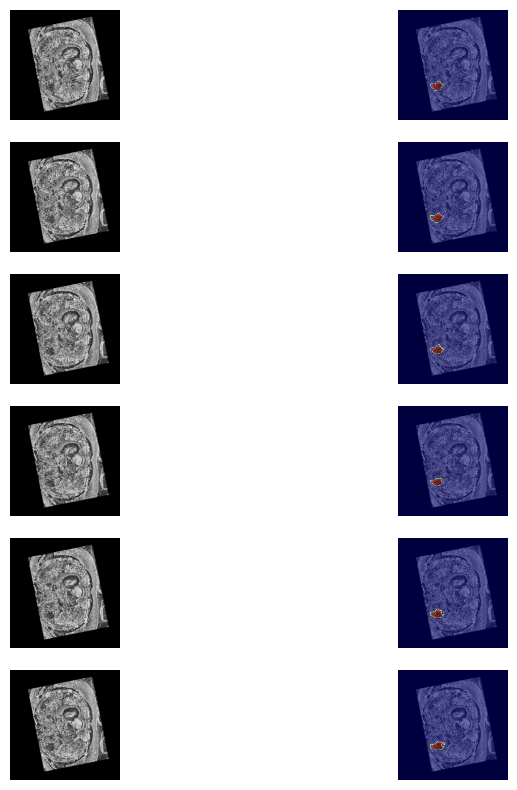

  0%|          | 1/912 [00:01<15:15,  1.00s/it]

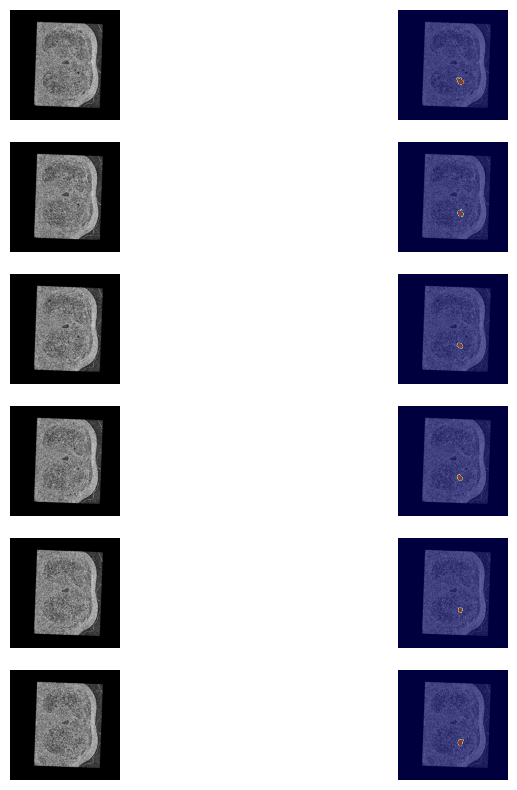

  0%|          | 2/912 [00:01<13:50,  1.10it/s]

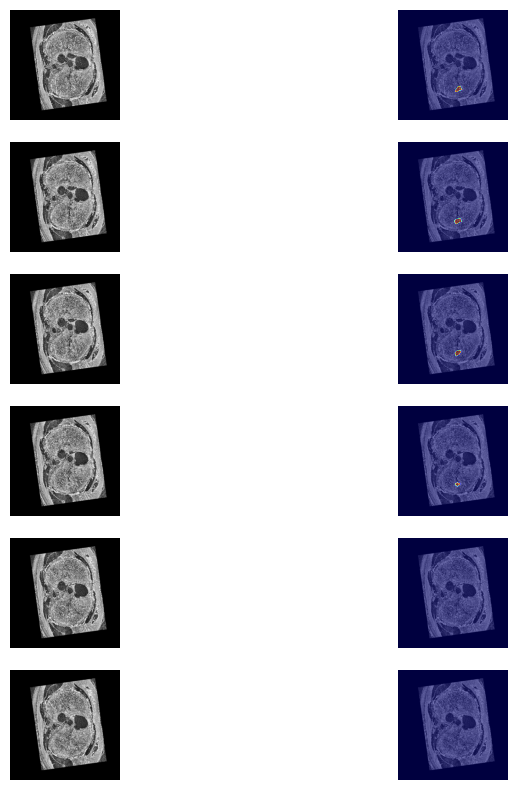

  0%|          | 2/912 [00:02<20:15,  1.34s/it]


In [27]:
for i in tqdm(range(len(msd_train_dataset))):
    img, label = msd_train_dataset[i]
    
    debug_plot(img, label)

    if i >= 2:
        break

    if img.max() == 0:
        print("Dataset is corrupted")
        break

torch.Size([1, 512, 512, 6]) torch.Size([1, 512, 512, 6])


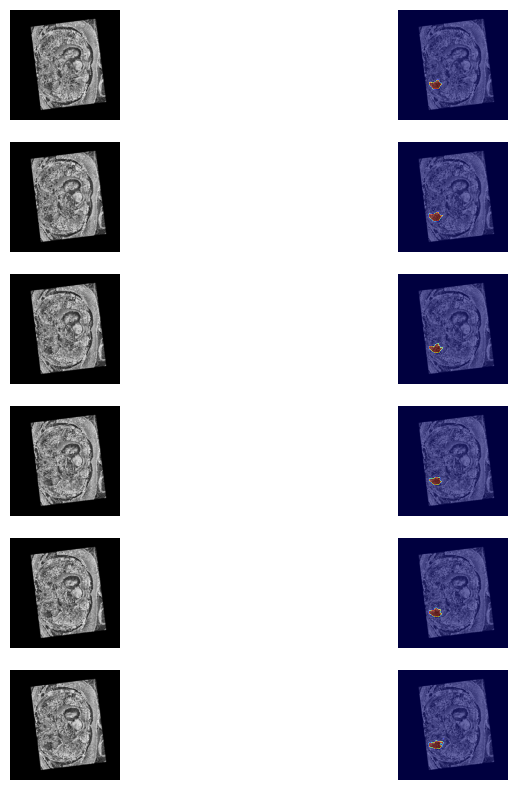

In [28]:
img, label = msd_train_dataset[0]

print(img.shape, label.shape)

output = train_transform({'image': img, 'label': label})

img_transformed, label_transformed = output['image'], output['label']

debug_plot(img_transformed, label_transformed)

In [29]:
class msdDatasetEvaluation(Dataset):
    def __init__(self, dataset_folder, transform = None, stack_size = 6, batch_size = 16, tumour_percent_threshold = 0.5, samples_proportion = 0.7, undersample_flag = False, undersample_size = 300):
        '''TODO: DOCUMENTAT MAI BINE AICI
        
        
        self.patients - contains (image, label) pairs for each patient in the dataset
        self.stacks_in_order_indices - contains the tuples (patient_id, stack_indices, other relevant attributes based on split_type) for each stack in the dataset
        
        '''
        self.img_folder = dataset_folder + "images/"
        self.label_folder = dataset_folder + "labels/"
        self.no_patients = len(os.listdir(self.img_folder))
        self.stack_size = stack_size
        self.batch_size = batch_size
        self.transform = transform

        split_type = 'training' if 'training' in dataset_folder else 'validation'

        # Flag that indicates we are working with the training dataset, we want to apply random rotations only for this split
        self.train_flag = split_type == 'training'

        print(split_type)
        self.patients = [self.get_img_and_label(i) for i in range(self.no_patients)]

        # If the indices for the dataset have been already built, load them, otherwise build them
        if os.path.exists(f'./ordered_nonoverlapping_{split_type}_indices_stack={stack_size}.pkl'):
            print(f'./ordered_nonoverlapping_{split_type}_indices_stack={stack_size}.pkl exists. Loading the ordered indices.')
            with open(f'./ordered_nonoverlapping_{split_type}_indices_stack={stack_size}.pkl', 'rb') as f:
                self.stacks_in_order_indices = pkl.load(f)
        else:
            print(f'./ordered_nonoverlapping_{split_type}_indices_stack={stack_size}.pkl does not exist. Building the ordered indices.')
            slices_per_patient = [self.patients[i][0].shape[-1] for i in range(self.no_patients)]
            self.stacks_in_order_indices = build_stack_ordered_nonoverlapping_indices(split_type, slices_per_patient, stack_size, self.patients, upload_flag = True)

        # self.device = device
        self.length = len(self.stacks_in_order_indices)


    def __len__(self):
        return self.length

    def get_img_and_label(self, patient_id):
        ''' Helper function: For a specified patient returns its image and label stacks from the dataset '''

        img = torch.load(self.img_folder + f'patient_{patient_id}.pt')
        label = torch.load(self.label_folder + f'patient_{patient_id}.pt')
        return img, label

    def __getitem__(self, idx):
        # print(f'Getting item {idx}/{len(self)}')
        # print(self.img_folder + f'patient_{patient_id}.pt')

        # Based on current index, get the patient_id and the slices that form the current stack

        if idx >= 0 and idx < self.length:
            stacks_tuple = self.stacks_in_order_indices[idx]

            patient_id, chosen_stacks = stacks_tuple[0], stacks_tuple[1]

            img, label = self.patients[patient_id]
            # Filters the current stack of images and labels for the current batch
            img, label = img[..., chosen_stacks], label[..., chosen_stacks]

            if self.train_flag and self.transform and stacks_tuple[3]:
                output = self.transform({'image': img, 'label': label})
                img, label = output['image'], output['label']

            # label = convert_labels_to_one_hot(label, 2) # Not needed for now, as MONAI handles the conversion internally
            return img, label
        else:
            raise IndexError

In [30]:
msd_val_dataset = msdDatasetEvaluation(datasets_path + val_name, transform = None)

validation
./ordered_nonoverlapping_validation_indices_stack=6.pkl exists. Loading the ordered indices.


  0%|          | 0/546 [00:00<?, ?it/s]

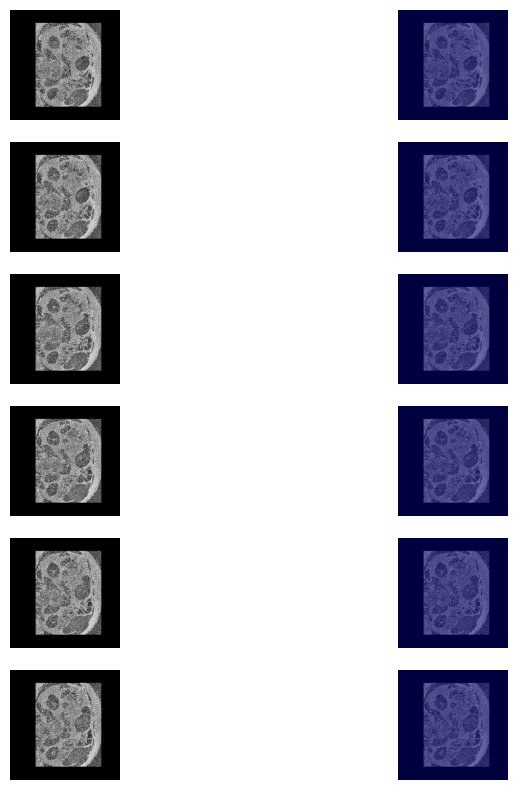

  0%|          | 1/546 [00:00<08:28,  1.07it/s]

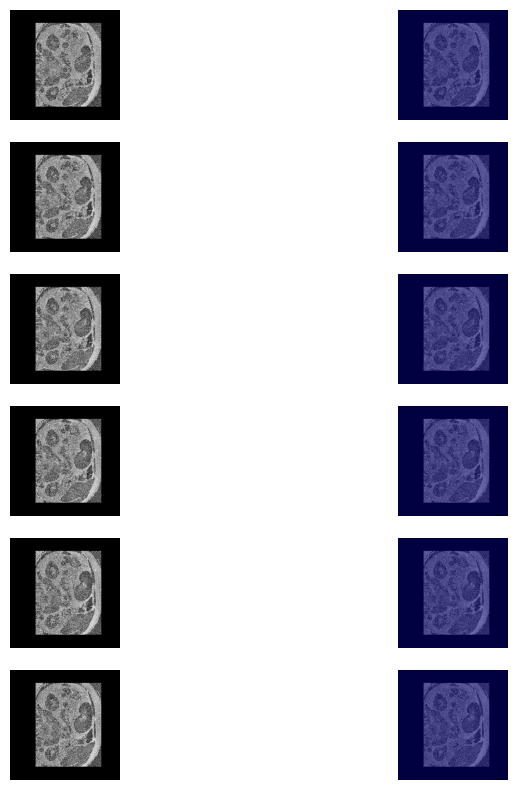

  0%|          | 2/546 [00:01<06:52,  1.32it/s]

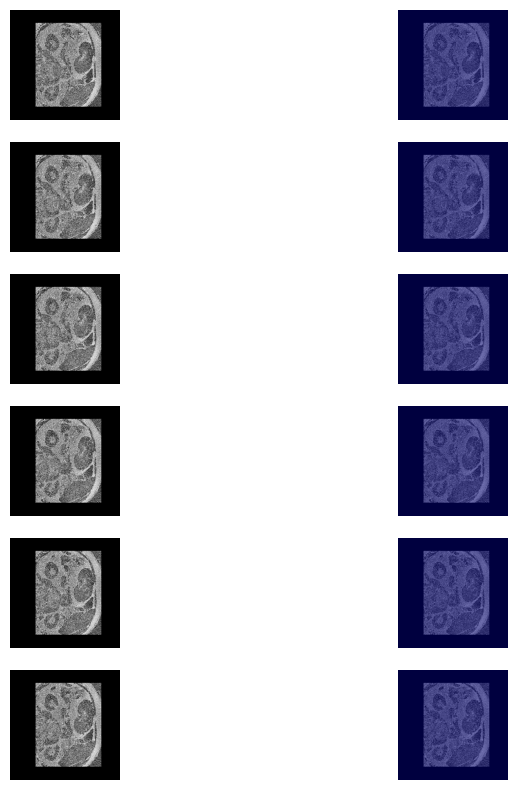

  0%|          | 2/546 [00:02<10:04,  1.11s/it]


In [31]:
for i in tqdm(range(len(msd_val_dataset))):
    img, label = msd_val_dataset[i]
    
    debug_plot(img, label)

    if i >= 2:
        break

    if img.max() == 0:
        print("Dataset is corrupted")
        break

In [32]:
len(msd_train_dataset), len(msd_val_dataset)

(912, 546)

In [33]:
train_loader = TorchDataLoader(msd_train_dataset, batch_size = BATCH_SIZE, shuffle = False, collate_fn=lambda x: tuple(x_ for x_ in default_collate(x))) # TODO: Comment collate_fn if it doesn't work

In [34]:
for img, label in tqdm(train_loader):
    break

    # no_healthy, no_ill = 0, 0

    # for i in range(BATCH_SIZE):
    #     if torch.sum(label[i, 0, ...]) > 1e-5:
    #         no_ill += 1
    #     else:
    #         no_healthy += 1

    # print("Healthy", no_healthy, "Ill", no_ill)




  0%|          | 0/76 [00:02<?, ?it/s]


In [35]:
val_loader = TorchDataLoader(msd_val_dataset, batch_size = BATCH_SIZE, shuffle = False, collate_fn=lambda x: tuple(x_ for x_ in default_collate(x))) #  num_workers = num_workers,

In [36]:
for a in tqdm(val_loader):
    # print(a[0].shape, a[1].shape)
    break

  0%|          | 0/46 [00:00<?, ?it/s]


In [37]:
debug_img, debug_label = next(iter(train_loader))

In [38]:
debug_img.shape, debug_label.shape

(torch.Size([12, 1, 512, 512, 6]), torch.Size([12, 1, 512, 512, 6]))

In [39]:
input_channels = debug_img.shape[1]
output_channels = 2*input_channels

In [40]:
debug_img, debug_label = debug_img.to(device), debug_label.to(device)

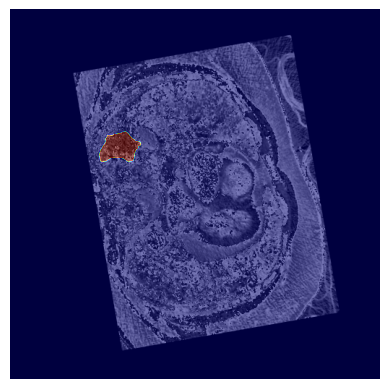

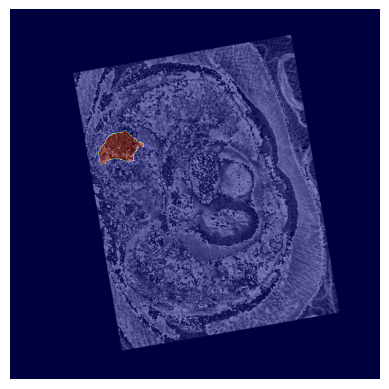

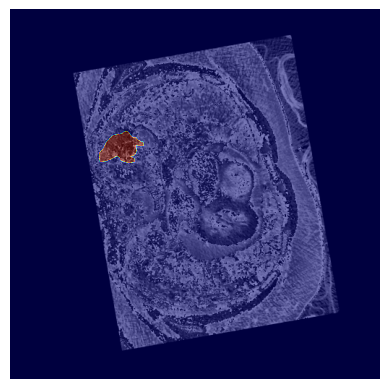

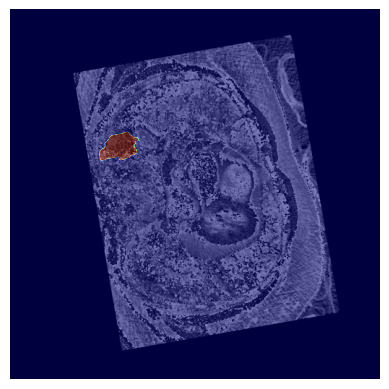

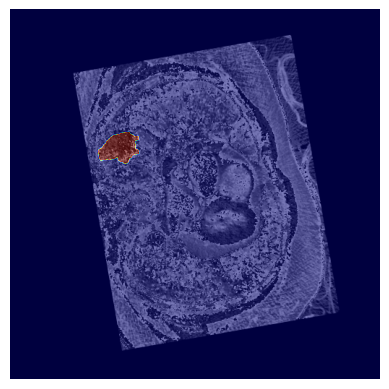

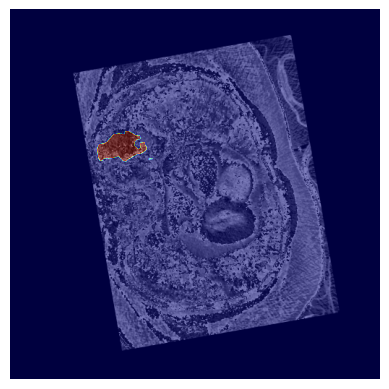

In [41]:
debug_plot_single(debug_img, debug_label)

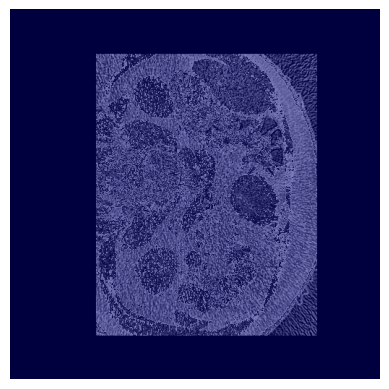

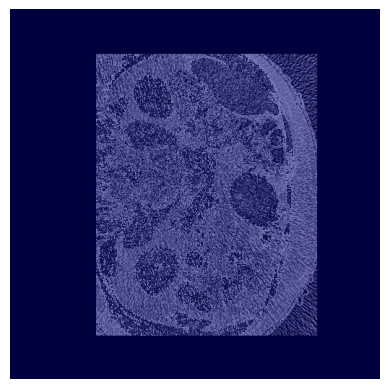

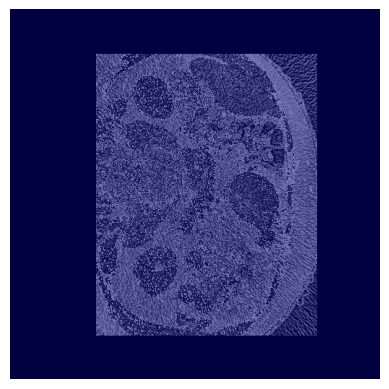

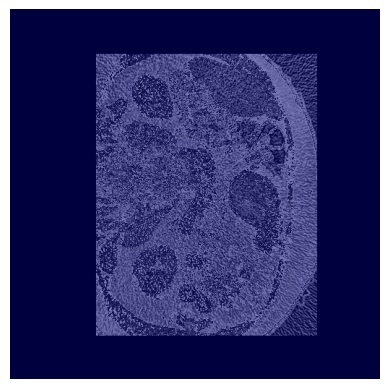

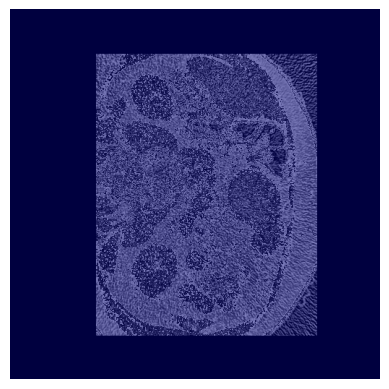

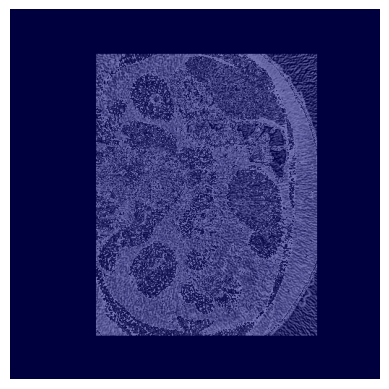

In [42]:
debug_img_val, debug_label_val = next(iter(val_loader))

debug_plot_single(debug_img_val, debug_label_val)

## MODEL

### MODEL HYPERPARAMS ###


In [43]:
# 100 EPOCHS:
UNet_metadata = dict(
    spatial_dims = 3,
    in_channels = 1,
    out_channels = 2,
    channels = (16, 32, 32, 128),
    kernel_size = (5, 5, 5),
    strides = (1, 2, 1, 2),
    num_res_units = 4,
    norm = Norm.BATCH,
    # act = torch.nn.ReLU,
    dropout = 0.1
)

# UNet_metadata = dict(
#     spatial_dims = 3,
#     in_channels = 1,
#     out_channels = 2,
#     channels = (16, 32, 128, 128),
#     kernel_size = (5, 5, 5),
#     strides = (1, 2, 1),
#     num_res_units = 4,
#     norm = Norm.BATCH,
#     # act = torch.nn.ReLU,
#     dropout = 0.1
# )


In [44]:
# Search available gpu devices for nn.DataParallel



In [45]:
# # Instantiate model
net = nn.Sequential(nn.BatchNorm3d(1, affine=True), UNet(**UNet_metadata), nn.InstanceNorm3d(2, affine=True))

net = nn.DataParallel(net)# device_ids = [0, 1, 2, 3]
net = net.to(device)
# net.load_state_dict(torch.load(best_previous_model_name))  #Used for finetuning when loading a previous model


# Xavier initialization
for name, param in net.named_parameters():
    if isinstance(param, nn.Linear):
        nn.init.xavier_normal_(param)
    elif 'bias' in name:
        nn.init.constant_(param, 0.05)

In [46]:
# net.state_dict()

In [47]:
debug_img.shape

torch.Size([12, 1, 512, 512, 6])

In [48]:
net(debug_img).shape

OutOfMemoryError: Caught OutOfMemoryError in replica 0 on device 0.
Original Traceback (most recent call last):
  File "/home/aimas/anaconda3/lib/python3.9/site-packages/torch/nn/parallel/parallel_apply.py", line 85, in _worker
    output = module(*input, **kwargs)
  File "/home/aimas/anaconda3/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1518, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/home/aimas/anaconda3/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1527, in _call_impl
    return forward_call(*args, **kwargs)
  File "/home/aimas/anaconda3/lib/python3.9/site-packages/torch/nn/modules/container.py", line 215, in forward
    input = module(input)
  File "/home/aimas/anaconda3/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1518, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/home/aimas/anaconda3/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1527, in _call_impl
    return forward_call(*args, **kwargs)
  File "/home/aimas/anaconda3/lib/python3.9/site-packages/monai/networks/nets/unet.py", line 300, in forward
    x = self.model(x)
  File "/home/aimas/anaconda3/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1518, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/home/aimas/anaconda3/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1527, in _call_impl
    return forward_call(*args, **kwargs)
  File "/home/aimas/anaconda3/lib/python3.9/site-packages/torch/nn/modules/container.py", line 215, in forward
    input = module(input)
  File "/home/aimas/anaconda3/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1518, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/home/aimas/anaconda3/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1527, in _call_impl
    return forward_call(*args, **kwargs)
  File "/home/aimas/anaconda3/lib/python3.9/site-packages/monai/networks/layers/simplelayers.py", line 129, in forward
    y = self.submodule(x)
  File "/home/aimas/anaconda3/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1518, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/home/aimas/anaconda3/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1527, in _call_impl
    return forward_call(*args, **kwargs)
  File "/home/aimas/anaconda3/lib/python3.9/site-packages/torch/nn/modules/container.py", line 215, in forward
    input = module(input)
  File "/home/aimas/anaconda3/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1518, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/home/aimas/anaconda3/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1527, in _call_impl
    return forward_call(*args, **kwargs)
  File "/home/aimas/anaconda3/lib/python3.9/site-packages/monai/networks/layers/simplelayers.py", line 129, in forward
    y = self.submodule(x)
  File "/home/aimas/anaconda3/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1518, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/home/aimas/anaconda3/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1527, in _call_impl
    return forward_call(*args, **kwargs)
  File "/home/aimas/anaconda3/lib/python3.9/site-packages/torch/nn/modules/container.py", line 215, in forward
    input = module(input)
  File "/home/aimas/anaconda3/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1518, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/home/aimas/anaconda3/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1527, in _call_impl
    return forward_call(*args, **kwargs)
  File "/home/aimas/anaconda3/lib/python3.9/site-packages/monai/networks/layers/simplelayers.py", line 129, in forward
    y = self.submodule(x)
  File "/home/aimas/anaconda3/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1518, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/home/aimas/anaconda3/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1527, in _call_impl
    return forward_call(*args, **kwargs)
  File "/home/aimas/anaconda3/lib/python3.9/site-packages/monai/networks/blocks/convolutions.py", line 317, in forward
    cx: torch.Tensor = self.conv(x)  # apply x to sequence of operations
  File "/home/aimas/anaconda3/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1518, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/home/aimas/anaconda3/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1527, in _call_impl
    return forward_call(*args, **kwargs)
  File "/home/aimas/anaconda3/lib/python3.9/site-packages/torch/nn/modules/container.py", line 215, in forward
    input = module(input)
  File "/home/aimas/anaconda3/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1518, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/home/aimas/anaconda3/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1527, in _call_impl
    return forward_call(*args, **kwargs)
  File "/home/aimas/anaconda3/lib/python3.9/site-packages/torch/nn/modules/container.py", line 215, in forward
    input = module(input)
  File "/home/aimas/anaconda3/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1518, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/home/aimas/anaconda3/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1527, in _call_impl
    return forward_call(*args, **kwargs)
  File "/home/aimas/anaconda3/lib/python3.9/site-packages/torch/nn/modules/container.py", line 215, in forward
    input = module(input)
  File "/home/aimas/anaconda3/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1518, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/home/aimas/anaconda3/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1527, in _call_impl
    return forward_call(*args, **kwargs)
  File "/home/aimas/anaconda3/lib/python3.9/site-packages/torch/nn/modules/batchnorm.py", line 171, in forward
    return F.batch_norm(
  File "/home/aimas/anaconda3/lib/python3.9/site-packages/torch/nn/functional.py", line 2478, in batch_norm
    return torch.batch_norm(
torch.cuda.OutOfMemoryError: CUDA out of memory. Tried to allocate 384.00 MiB. GPU 0 has a total capacty of 31.73 GiB of which 146.94 MiB is free. Process 46415 has 10.70 GiB memory in use. Process 47464 has 10.28 GiB memory in use. Including non-PyTorch memory, this process has 10.06 GiB memory in use. Of the allocated memory 9.48 GiB is allocated by PyTorch, and 36.97 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF


In [ ]:
### LOSS ###
loss_functions = {
    'dice': DiceLoss(to_onehot_y = True, softmax = True, include_background=False),
    'cross_entropy': nn.CrossEntropyLoss(),
    'custom': nn.BCELoss()
}

loss_key = 'dice'

loss_function = loss_functions[loss_key]


In [ ]:
LEARNING_RATE = 5e-3
wd = 1e-4

In [ ]:
optimizers = { 'adam' : torch.optim.Adam, 'sgd' : torch.optim.SGD, 'nadam' : torch.optim.NAdam, 'rmsprop' : torch.optim.RMSprop, 'adamw' : torch.optim.AdamW}
optimizer_key = 'nadam'

# Instantiate optimizer
decayRate = 1  #- 1e-3
optimizer = optimizers[optimizer_key](net.parameters(), lr = LEARNING_RATE, weight_decay = wd)

# Instantiate learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=decayRate)


In [ ]:
### PERFORMANCE METRICS ###
dice_metric = DiceHelper(include_background = False, reduction = "mean", get_not_nans=False, ignore_empty=True) # include_background = False,
iou_metric = MeanIoU(include_background=False, reduction = "mean", get_not_nans=False, ignore_empty=True)

### TRAINING PROCEDURE ###

In [53]:
def train(device, model, model_name, train_dataset, train_loader, val_loader, loss_function, optimizer, lr_scheduler, MAX_EPOCHS=20, VALIDATION_INTERVAL=2, EPOCH_OFFSET : int = 0):
    
    no_batches = len(train_loader)
    
    lr_val = optimizer.defaults[LEARNING_RATE_NAME]
    wd_val = optimizer.defaults[WEIGHT_DECAY_NAME]

    # Variables to get the best model
    best_dice = -1
    best_metrics = None
    best_metric_epoch = -1

    general_name = f'clahe_{model_name}_{optimizer_key}_lr{lr_val:.2e}_wd{wd_val:.2e}_{loss_key}loss'
    best_model_name = checkpoints_path + f'{general_name}_best.pth'

    print(best_model_name)
    writer = SummaryWriter(log_dir=f"./pytorch_logging/{general_name}_epochs{MAX_EPOCHS}")


    # Evaluation metrics per epoch
    dice_values = []
    iou_values = []

    epoch_loss_values = []

    for epoch in range(1 + EPOCH_OFFSET, MAX_EPOCHS + 1):
        print("-" * 12)
        print(f"Epoch {epoch}/{MAX_EPOCHS}")

        # Turn model to "train" mode
        model.train()

        epoch_loss = 0
        for step, batch_data in enumerate(train_loader):
            step += 1

            train_input, label = batch_data
            train_input, label = train_input.to(device), label.to(device)

            optimizer.zero_grad() # Clear gradients
            output = model(train_input)

            loss = loss_function(output, label)
            loss.backward() # Compute gradient

            # Clip gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1, norm_type=2)
            optimizer.step() # Update model's parameters

            epoch_loss += loss.item()
            print(f"{step}/{no_batches}, train_loss: {loss.item():.4f}")

        epoch_loss /= step
        epoch_loss_values.append(epoch_loss)
        writer.add_scalar('Loss/train', epoch_loss, epoch)

        print(f"epoch {epoch} average loss: {epoch_loss:.4f}")

        # if epoch % 5 == 2:
        #     # Decay learning rate
        #     lr_scheduler.step()

        if epoch % VALIDATION_INTERVAL == 0:
            # Save current checkpoint of the network

            print(f"Saving checkpoint: {epoch//VALIDATION_INTERVAL} / {MAX_EPOCHS//VALIDATION_INTERVAL}!!!")
            name = checkpoints_path + f'{general_name}_epoch{epoch}.pth'
            torch.save(model.state_dict(), name)

            # Turn model to "eval" mode
            model.eval()

            # Disabling gradient calculation is useful for inference, when you are sure that you will not call Tensor.backward().
            # It will reduce memory consumption for computations that would otherwise have requires_grad=True
            with torch.no_grad():
                iteration_dice = []
                # iteration_ious = []
                # iteration_pixel_accuracies = []
                # iteration_rvds = []

                for val_data in val_loader:
                    val_input, val_label = val_data
                    val_input, val_label = val_input.to(device), val_label.to(device)

                    val_output = model(val_input)
                    val_output = nn.Softmax(dim=1)(val_output)

                    # Compute metrics for current iteration
                    iteration_dice.append(dice_metric(y_pred = val_output, y = val_label).item())
                    iou_metric(y_pred= val_output, y=val_label)

            # Aggregate the final mean results
            dice_score = torch.mean(torch.tensor(iteration_dice)).item()
            mean_iou = iou_metric.aggregate().item()

            # Reset the status for the next epoch
            # dice_metric.reset()
            iou_metric.reset()

            dice_values.append(dice_score)
            iou_values.append(mean_iou)

            writer.add_scalar('Dice/val', dice_score, epoch)
            writer.add_scalar('IoU/val', mean_iou, epoch)

            if dice_score > best_dice:
                best_dice = dice_score
                best_metrics = (dice_score, mean_iou)
                best_metric_epoch = epoch + 1
                print("saved new best metric model!!!")

                torch.save(model.state_dict(), best_model_name)

            print(
                f"current epoch: {epoch + 1},"
                f" current mean dice: {dice_score:.4f},"
                f" current mean iou: {mean_iou:.4f},"
                f" best mean dice: {best_dice:.4f},"
                f" at epoch: {best_metric_epoch}"
            )

        train_dataset.shuffle()

    print(
        f"train completed, metrics correspondic to best dice are: dice: {best_metrics[0]:.4f}, iou: {best_metrics[1]:.4f}" #, acc: {best_metrics[2]:.4f}, rvd: {best_metrics[3]:.4f}"
        f" at epoch: {best_metric_epoch}"
    )

    with open(checkpoints_path + f'{general_name}_metrics_evolution.pkl', 'wb') as f:
        pkl.dump((dice_values, iou_values, epoch_loss_values), f)

    writer.close()

    return best_model_name


In [54]:
best_model_name = train(device, net, model_name, msd_train_dataset, train_loader, val_loader, loss_function, optimizer, lr_scheduler, MAX_EPOCHS=300, VALIDATION_INTERVAL=2, EPOCH_OFFSET=0)

/home/aimas/Desktop/Disertatie_CataChiru/LungCancerCT/checkpoints/UNET/clahe_unet_nadam_lr5.00e-03_wd1.00e-04_diceloss_best.pth
------------
Epoch 1/300
1/76, train_loss: 0.9940
2/76, train_loss: 0.9948
3/76, train_loss: 0.9842
4/76, train_loss: 0.9884
5/76, train_loss: 0.9914
6/76, train_loss: 0.9922
7/76, train_loss: 0.9927
8/76, train_loss: 0.9891
9/76, train_loss: 0.9911
10/76, train_loss: 0.9918
11/76, train_loss: 0.9815
12/76, train_loss: 0.9944
13/76, train_loss: 0.9857
14/76, train_loss: 0.9830
15/76, train_loss: 0.9912
16/76, train_loss: 0.9908
17/76, train_loss: 0.9823
18/76, train_loss: 0.9864
19/76, train_loss: 0.9894
20/76, train_loss: 0.9874
21/76, train_loss: 0.9797
22/76, train_loss: 0.9874
23/76, train_loss: 0.9921
24/76, train_loss: 0.9885
25/76, train_loss: 0.9887
26/76, train_loss: 0.9890
27/76, train_loss: 0.9923
28/76, train_loss: 0.9916
29/76, train_loss: 0.9824
30/76, train_loss: 0.9919
31/76, train_loss: 0.9896
32/76, train_loss: 0.9843
33/76, train_loss: 0.985

In [ ]:
best_model_name

In [ ]:
# Get net weights
net.state_dict()

In [ ]:
best_model_name

In [ ]:
%load_ext tensorboard
%reload_ext tensorboard

%tensorboard --logdir=./pytorch_logging/unet_adam_lr3.00e-03_diceloss_epochs50/

### VALIDATION PROCEDURE ###

In [ ]:
val_name = './checkpoints/UNET/min-max3_augmented_unet_nadam_lr5.00e-04_wd1.00e-03_diceloss_epoch2.pth'

In [ ]:
val_net = net

In [ ]:
# TODO: Verificat dupa ce rezolv restul lucrurilor de ce nu merge loadul ca lumea
val_net = nn.Sequential(nn.BatchNorm3d(1, affine=True), UNet(**UNet_metadata), nn.InstanceNorm3d(2, affine=True))
val_net = nn.DataParallel(val_net, device_ids = [0, 1, 2, 3])
val_net = val_net.to(device)
val_net.load_state_dict(torch.load(val_name))


In [ ]:
# IDIOT PROOF "IT WORKS WELL" TEST - VALIDATION LOADER #
for val_data1 in val_loader:
    val_input1, val_label1 = val_data1
    break


they_are_ordered = True

for i in range(val_input1.shape[0]):
    they_are_ordered &= (val_input1[i][0] == msd_val_dataset[i][0]).all()

print(f"Same order test1: {they_are_ordered}")

i = 3
skipped_images = 0
for val_data2 in val_loader:
    if i > 0:
        i -= 1
        skipped_images += val_data2[0].shape[0]
        continue
    else:
        val_input2, val_label2 = val_data2
        break

print(f"No of skipped images: {skipped_images}")
for j in range(3*val_input2.shape[0], 4*val_input2.shape[0]):
    print("Index of image in batch: ", j % val_input2.shape[0], " || ", "Index of image in dataset: ", j)
    they_are_ordered &= (val_input2[j % val_input2.shape[0]][0] == msd_val_dataset[j][0]).all()

print(f"Same order test2: {they_are_ordered}")

In [ ]:
# IDIOT PROOF "IT WORKS WELL" TEST - LR SCHEDULER LOADER #
future_lr1 = lr_scheduler.get_last_lr()[0] * decayRate

lr_scheduler.step()
future_lr2 = lr_scheduler.get_last_lr()[0]

print(f"LR works as expected: {future_lr1 == future_lr2}")

In [ ]:
def hard_threshold_labels(labels, threshold = 0.5, cutoff_flag = False):
    '''Thresholds the labels to 0 or 1 based on a specified threshold.'''

    sigmoid_activation = Activations(sigmoid=True)

    labels = sigmoid_activation(labels)


    if cutoff_flag:
        hard_thresholding = AsDiscrete(threshold=threshold)
        mask_from_background = (1 - labels[1])
        mask = labels[0]

        # Mean based on the two masks
        labels = (mask_from_background + mask) / 2
        max_value = torch.max(labels)
        min_value = torch.min(labels)

        if max_value > 0:
            labels = (labels - min_value) / (max_value - min_value)

        labels = hard_thresholding(labels)
        labels = np.expand_dims(labels, 0)
        # print(labels.shape)

    return labels

In [ ]:
def plot_prediction_label_side_by_side(img, label, prediction, threshold = 0.5):
    '''
    Plots a 2 x 3 grid with the image, label and prediction side by side on the first row.

    On the second row, the image is plotted with the label and prediction overlayed.
    '''

    for i in range(img.shape[0]):
        print(i)
        if i > 1:
            break
        im = img[i].to('cpu').detach().numpy()
        target = label[i].to('cpu').detach().numpy()
        output = prediction[i].to('cpu').detach().numpy()
        # output = hard_threshold_labels(output, threshold, cutoff_flag = False)

        for j in range(img.shape[-1]):
            fig, ax = plt.subplots(2, 3, figsize=(15, 5))

            ax[0, 0].imshow(im[0, ..., j], cmap = 'gray')
            ax[0, 1].imshow(target[0, ..., j], cmap = 'jet')
            im1 = ax[0, 2].imshow(output[1, ..., j], cmap = 'jet')
            ax[1, 0].imshow(im[0, ..., j], cmap = 'gray')
            ax[1, 1].imshow(im[0, ..., j], cmap = 'gray')
            ax[1, 1].imshow(target[0, ..., j], cmap = 'jet', alpha = 0.5)
            ax[1, 2].imshow(im[0, ..., j], cmap = 'gray')
            im2 = ax[1, 2].imshow(output[1, ..., j], cmap = 'jet', alpha = 0.5)

            plt.colorbar(im1, ax=ax[0, 2])
            plt.colorbar(im2, ax=ax[1, 2])  

            for k in range(2):
                for l in range(3):
                    ax[k, l].invert_yaxis()
                    ax[k, l].set_axis_off()

                    if k == 0:
                        ax[k, l].set_title(['Image', 'Label', 'Prediction'][l])
                    if i == 1:
                        ax[k, l].set_title(['Image', 'Label overlay', 'Prediction overlay'][l])


            # TODO: In alta zi, fa tight layout
            fig.tight_layout()
            plt.show()


In [ ]:
qualitative_plots_flag = False
save_qualitative_plots_flag = True

In [ ]:
### PERFORMANCE METRICS ###
dice_metric_eval = DiceHelper(include_background = False, reduction = "mean", get_not_nans=False, ignore_empty=True) # include_background = False,
iou_metric_eval = MeanIoU(include_background=False, reduction = "mean", get_not_nans=False, ignore_empty=True)

In [ ]:
if save_qualitative_plots_flag:
    if not os.path.exists('./plots'):
        os.mkdir('./plots')
        os.mkdir(f'./plots/{model_name.upper()}')
        os.mkdir(f'./plots/{model_name.upper()}/images')
        os.mkdir(f'./plots/{model_name.upper()}/gifs')

    if not os.path.exists(f'./plots/{model_name.upper()}'):
        os.mkdir(f'./plots/{model_name.upper()}')
        os.mkdir(f'./plots/{model_name.upper()}/images')
        os.mkdir(f'./plots/{model_name.upper()}/gifs')


In [ ]:
def precision_score_(groundtruth_mask, pred_mask):
    intersect = np.sum(pred_mask*groundtruth_mask)
    total_pixel_pred = np.sum(pred_mask)
    precision = np.mean(intersect/total_pixel_pred)
    return round(precision, 3)

def recall_score_(groundtruth_mask, pred_mask):
    intersect = np.sum(pred_mask*groundtruth_mask)
    total_pixel_truth = np.sum(groundtruth_mask)

    if total_pixel_truth == 0:
        if np.sum(pred_mask) == 0:
            return 1
        else:
            return 0

        
    recall = np.mean(intersect/total_pixel_truth)
    return round(recall, 3)

def dice_coef(groundtruth_mask, pred_mask):
    intersect = np.sum(pred_mask*groundtruth_mask)
    total_sum = np.sum(pred_mask) + np.sum(groundtruth_mask)
    dice = np.mean(2*intersect/total_sum)
    return round(dice, 3) #round up to 3 decimal places

def iou(groundtruth_mask, pred_mask):
    intersect = np.sum(pred_mask*groundtruth_mask)
    union = np.sum(pred_mask) + np.sum(groundtruth_mask) - intersect
    iou = np.mean(intersect/union)
    return round(iou, 3)

In [ ]:
no_val_iters = 0
loss_val = []
dice_val = []
iou_val = []
precision_val = []
recall_val = []

post_pred = Compose([AsDiscrete(argmax=True, to_onehot=2)])
post_label = Compose([AsDiscrete(to_onehot=2)])

save_val_data = []

with torch.no_grad():
    val_net.eval()

    count_plots = 0
    idx = 0

    for batch in val_loader:
        val_img, val_label = batch
        val_img, val_label = val_img.to(device), val_label.to(device)

        val_output = val_net(val_img)
        val_output = nn.Softmax(dim=1)(val_output)

        # roi_size = (512, 512, 2)
        # sw_batch_size = 1
        # val_outputs_dice = sliding_window_inference(val_img, roi_size, sw_batch_size, val_net)

        # val_outputs_dice = []
        # for val_crt_output in decollate_batch(val_outputs_dice):
        #     print(val_crt_output == None)
        #     print(val_crt_output.shape)
        #     val_outputs_dice.append(post_pred(nn.Softmax(dim=1)(val_crt_output)))

        # val_label_dice = []
        # for crt_label in decollate_batch(val_label):
        #     val_label_dice.append(post_label(crt_label))

        # compute metric for current iteration
        dice_val.append(dice_metric_eval(y_pred=val_output, y=val_label).item())
        # dice_val.append(dice_coef(val_label[1].to('cpu').detach().numpy(), val_output[1].to('cpu').detach().numpy()))
        # precision_val.append(precision_score_(val_label[1].to('cpu').detach().numpy(), val_output[1].to('cpu').detach().numpy()))
        # recall_val.append(recall_score_(val_label[1].to('cpu').detach().numpy(), val_output[1].to('cpu').detach().numpy()))
        # iou_val.append(iou(val_label[1].to('cpu').detach().numpy(), val_output[1].to('cpu').detach().numpy()))
        iou_metric_eval(y_pred=val_output, y=val_label)
        # print("Dice score : ", dice_metric_eval.aggregate().item())
        # print("IoU score : ", iou_metric_eval.aggregate().item())
        # print("Loss : ", loss_function(val_output, val_label).item())

        # dice_val.append(dice_metric_eval.aggregate().item())
        # loss_val.append(loss_function(val_output, val_label).item())
        # iou_val.append(iou_metric_eval.aggregate().item())
        # no_val_iters += 1


        # if recall_val[-1] > 0.8:
        #     save_val_data.append((val_img, val_label, val_output, recall_val[-1]))
        

        if qualitative_plots_flag:
            plot_prediction_label_side_by_side(val_img, val_label, val_output, threshold = 0.5)
            break

        if save_qualitative_plots_flag:

            for i in range(val_img.shape[0]):

                if idx == len(msd_val_dataset):
                    sys.exit()

                print(f"Current index: {idx} / {len(msd_val_dataset)}")
                # Don't save images for the padding indices
                # Only iterate through the unique slices for each patient
                patient_id, slices = msd_val_dataset.stacks_in_order_indices[idx]
                slices = np.unique(slices)
                
                # if patient_id > 0:
                #     sys.exit()

                im = val_img[i].to('cpu').detach().numpy()
                target = val_label[i].to('cpu').detach().numpy()
                output = val_output[i].to('cpu').detach().numpy()

                # Normalize the output to 0 or 1
                # output = hard_threshold_labels(output)

                idx += 1
                for j in range(len(slices)):
                    plt.imshow(im[0, ..., j], cmap = 'gray')
                    plt.imshow(output[1, ..., j], cmap = 'jet', alpha = 0.5)
                    plt.gca().set_axis_off()

                    plt.savefig(f'./plots/{model_name.upper()}/images/patient{patient_id}_slice{slices[j]}.png')
                    plt.close()

    # Aggregate the final mean results
    dice_score_eval = torch.mean(torch.tensor(dice_val)).item()
    mean_iou_eval = iou_metric_eval.aggregate().item()
    # mean_iou_eval = torch.mean(torch.tensor(iou_val)).item()
    p_score_eval = np.mean(precision_val)
    r_score_eval = np.mean(recall_val)


    # # Reset the status
    # dice_metric_eval.reset()
    # iou_metric_eval.reset()

    print(f"Evaluation metrics: dice: {dice_score_eval:.4f}, iou: {mean_iou_eval:.4f}, precision: {p_score_eval:.4f}, recall: {r_score_eval:.4f}")

In [ ]:

for (val_img, val_label, val_output, crt_recall) in save_val_data:
    
    print(f'Recall score: {crt_recall}')
    for i in range(val_img.shape[-1]):
        im = val_img[0].to('cpu').detach().numpy()
        target = val_label[1].to('cpu').detach().numpy()
        output = val_output[1].to('cpu').detach().numpy()

        fig, axes = plt.subplots(1, 2, figsize=(15, 5))
        axes[0].imshow(im[0, ..., i], cmap = 'gray')
        axes[0].imshow(target[0, ..., i], cmap = 'jet', alpha = 0.5)

        axes[1].imshow(im[0, ..., i], cmap = 'gray')
        axes[1].imshow(output[1, ..., i], cmap = 'jet', alpha = 0.5)

        for j in range(2):
            axes[j].invert_yaxis()
            axes[j].set_axis_off()
            

        plt.show()



In [ ]:
plt.plot(dice_val, label = 'Dice')
plt.plot(iou_val, label = 'IoU')
plt.plot(precision_val, label = 'Precision')
plt.plot(recall_val, label = 'Recall')
plt.plot(loss_val, label = 'Loss')
plt.legend()
plt.show()

In [ ]:
no_val_iters, len(dice_val)

In [ ]:
# IDIOT PROOF "IT WORKS WELL" TEST - MONAI ONE HOT ENCODING MAP #

from monai.networks.utils import one_hot
# Search for a slice with a tumour

for i in range(len(msd_val_dataset)):
    if(msd_val_dataset[i][1].sum() > 3000):
        single_label = msd_val_dataset[i][1].unsqueeze(0).to('cpu')
        print("OK")
        break

# See how the label looks like
plt.imshow(single_label[0, 0, ..., 3].to('cpu').detach().numpy(), cmap = 'gray')
plt.show()


print("ONE HOT ENCODING TEST")
# See how the one-hot encoding looks like splitted in background and tumour
one_hot_lbl = one_hot(single_label, 2)
one_hot_lbl = one_hot_lbl.detach().cpu().numpy()

plt.imshow(one_hot_lbl[0, 0, ..., 3], cmap = 'gray')
plt.show()
plt.imshow(one_hot_lbl[0, 1, ..., 3], cmap = 'gray')
plt.show()

### NUMBER OF TRAINABLE PARAMETERS

In [ ]:
from prettytable import PrettyTable

def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad:
            continue
        params = parameter.numel()
        table.add_row([name, params])
        total_params += params
    print(table)
    # Get the total number of parameters as millions
    print(f"Total Trainable Params: {total_params/1e6:.2f} M params")
    return total_params
    
count_parameters(net)